In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from gensim import models

In [ ]:
import gensim #imp

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
model_path = '/content/drive/MyDrive/Nagasaki Internship/GoogleNews-vectors-negative300.bin.gz'            # Path where the model is stored
#model_w2v = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)            # Loading the model using gensim

In [ ]:
pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model_w2v = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)   # Loading the model using gensim

In [ ]:
import json
import h5py
import numpy as np
import copy
from random import shuffle, seed
import sys
import os.path
import argparse
import glob
import numpy as np
import scipy.io
import pdb
import string
import h5py
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import gensim
import json
import re
import cv2
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def extract_feat(doc):
  '''
  
  '''
  feat = []
  for word in doc:
      try:
          feat.append(model_w2v[word])
      except:
          pass
  return feat

def tokenize(sentence):

    ''' Perform Tokenization '''
    return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])", sentence) if i!='' and i!=' ' and i!='\n'];

def prepro_question(imgs, method):
    # preprocess all the question
    print('example processed tokens:')

    '''
    Input: The question from trainset.json
    Performs tokenization and lowering of the question
    Output: Embedded version of the question

    Note that: We have still not padded the questions, just for information each of the word will be a 300 Dimensional Vector,
    hence, the word vector (which will be obtained after padding) will be a (21,300) Dimensional
    '''
    for i,img in enumerate(imgs):
        s = img['question'].lower()
        if method == 'nltk':
            txt = word_tokenize(str(s).lower())
        else:
            txt = tokenize(s)
        img['processed_tokens'] = txt
        if i < 10: print(txt)
        if i % 1000 == 0:
            sys.stdout.write("processing %d/%d (%.2f%% done)   \r" %  (i, len(img), i*100.0/len(imgs)) )
            sys.stdout.flush()   
    return imgs

def get_top_answers(imgs, num_ans):

    """
    Print the questions and returns the time, one answer is repeated
    """
    counts = {}
    for img in imgs:
        try:
            ans = img['answer'].lower()  # If the string is a number, it would result into error
        except :
            ans = str(img['answer'])
        counts[ans] = counts.get(ans, 0) + 1

    cw = sorted([(count,w) for w,count in counts.items()], reverse=True)
    print('top answer and their counts:') 
    print('\n'.join(map(str,cw[:20])))
    
    vocab = []
    for i in range(min(num_ans,len(cw))):
        vocab.append(cw[i][1])

    return vocab[:num_ans]


def filter_question(imgs, atoi):

  ''' Not of much use, I had used it for some other purpose, but did not use it later '''
  new_imgs = []
  for i, img in enumerate(imgs):
        new_imgs.append(img)

  print('question number reduce from %d to %d '%(len(imgs), len(new_imgs)))
  return new_imgs

manualMap = { 'none': '0', 'zero': '0', 'one': '1', 'two': '2', 'three':
                  '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7',
                  'eight': '8', 'nine': '9', 'ten': '10' }

imgs_train = json.load(open('/content/drive/MyDrive/Nagasaki Internship/med-vqa-main/trainset.json' , 'r'))      # Unnnecesarily, i have used the same file two times
num_ans = 1000
top_ans = get_top_answers(imgs_train, num_ans)                         
atoi = {w:i for i,w in enumerate(top_ans)}                   # Word : Count
itoa = {i:w for i,w in enumerate(top_ans)}                   # Count : Word
feat_dim = 300                                               # 300 Dimensional Vector
imgs_data_train = json.load(open('/content/drive/MyDrive/Nagasaki Internship/med-vqa-main/trainset.json' , 'r'))  # trainset.json
num_ans = 10    # Even 1 should work fine, but I had taken reference from COCO dataset, and hence, 10 (10 represents the top 10 answers to a picture)
method = 'nltk'
max_length = 21                       # Max Length of the question
dir_path = "/content/drive/MyDrive/Nagasaki Internship/qa"    # The path where we will be storing .h5 file
N = len(imgs_data_train)

image_path = '/content/drive/MyDrive/Nagasaki Internship/med-vqa-main/VQA_RAD Image Folder'


def save_data():
    
 
        for i,img in enumerate(imgs_data_train):
            #print('X' , img['ques_id'])
            img_path = image_path+img['image_name']  

            s = img['question']
            print(i,s)   # Print the number and the question
            if method == 'nltk':
                try:
                    txt = word_tokenize(str(s).lower())
                except :
                    txt = str(s)
            else:
                    txt = tokenize(s)

            img['processed_tokens'] = txt            
            question_id = img['qid']
            feat = np.array(extract_feat(img['processed_tokens']))
            label_arrays = np.zeros((1, max_length, feat_dim), dtype='float32')
            label_length = min(max_length, len(feat)) # record the length of this sequence
            label_arrays[0, :label_length, :] = feat
            try:
                ans_arrays = atoi[img['answer'].lower()]
            except :
                ans_arrays = atoi[str(img['answer'])]

            f = h5py.File(os.path.join( dir_path , str(question_id) + '.h5'), "w")
            f.create_dataset("ques_train", dtype='float32', data=label_arrays)
            f.create_dataset("answers", dtype='uint32', data=ans_arrays)
            f.close()
        return    
 
data = save_data()

top answer and their counts:
(884, 'no')
(829, 'yes')
(35, 'right')
(31, 'axial')
(23, 'left')
(15, 'fat')
(14, 'pa')
(12, 'right lung')
(12, 'pancreas')
(12, 'one')
(11, 'left kidney')
(11, 'diffuse')
(10, 'right upper lobe')
(10, 'right sided pleural effusion')
(10, 'right side')
(10, 'ct')
(10, 'brain')
(9, 'lateral ventricles')
(9, 'bilateral')
(8, 'subarachnoid')
0 Are regions of the brain infarcted?
1 Are the lungs normal appearing?
2 Is there evidence of a pneumothorax
3 What type of imaging does this not represent?
4 Is this a MRI of the chest?
5 What is not pictured in this image?
6 Is the trachea midline?
7 Is there evidence of an aortic aneurysm?
8 Where is the abnormality?
9 Is there blunting of the costovertebral angles?
10 Which organ system is abnormal in this image?
11 Where is the pathology in this image?
12 Is there a pneumothorax?
13 What type of imaging is this?
14 What organ system is pictured?
15 Is there a fracture?
16 Is there swelling of the grey matter?
17 Is 

In [ ]:
def image_layer(input_shape):
    '''
    Input : Shape of the image
    Output : VGG16 Preprocessing model
    '''
    base_model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False,weights='imagenet')
    base_model.trainable = False # Do not train it
    x = base_model.layers[-2].output  # Shape would be (28*28*512)
    x = tf.reshape(x , [-1,x.shape[2]*x.shape[1] , x.shape[3]]) # Shape would be (1,784,512)
    x = tf.keras.layers.Dense(1024)                            # This step can be found out in the slides, that after feature extraction, they are connecting a dense layer, slide - 6 (Transform into a same size vector)
    return x

def vgg_preprocessing(model,image):
  ''' Takes a tensor as an input, and returns a pre processed version of the image'''
  return model(image)

def load_data():

        '''
        Input: Nothing

        Output: Returns list containing the following four elements in a tuple
        (preprocessed version of the image,embedded question,embedded answer, question id)
        '''
        
        images = []
        questions = []
        answers = []
        ids = []
        
        #print(start,end)
        #arrs = np.random.randint(0,len(imgs_data_train),batch)
        #data = [imgs_data_train[i] for i in arrs]
        
        data = imgs_data_train   # trainset.json
        model = image_layer(input_shape = (448,448,3)) # Making VGG16 Model
        for i,img in enumerate(data):
        
            img_path = img['image_name']  # Image Name
            question_id = img['qid']      # Question id

            #label_arrays = np.zeros((1, max_length, feat_dim), dtype='float32') # Somethings are taken directly from 
            
            with h5py.File(os.path.join(dir_path,str(question_id) + '.h5'),'r') as hf:
               question = hf['.']['ques_train'][()] # Embedded question
               answer = hf['.']['answers'][()]    # Embedded answer
    #             # return a h5py dataset object:
    #              question = hf[ques_train]
    # # return a h5py dataset object:
    #              answer = hf[answers][:]
         
            image = cv2.imread(os.path.join('/content/drive/MyDrive/Nagasaki Internship/med-vqa-main/VQA_RAD Image Folder',img_path) , cv2.IMREAD_COLOR) # Reading the image
            image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
            image = cv2.resize(image , (448,448)) # Reshape

            '''
            Small Note : I had not applied the VGG Preprocessing here, because I wanted to use the original shape of 448, and then, I would 
            attach the VGG Model, while making the model, I think this makes sense :)
            '''
            #image = vgg_preprocessing(model,image)
            # Apply VGG16 Preprocessings

            images.append(image)
            questions.append(np.array(question))
            answers.append(np.array(answer))
            ids.append(question_id)     
            if i%100==0:
              print("Processed =>",i,' which is',round(100*i/len(data),2),'%')          
        
        questions = np.reshape(np.array(questions) , [-1,max_length,feat_dim])
        return (np.array(images) , questions ,np.array(answers) , np.array(ids))

imgs_train = json.load(open('/content/drive/MyDrive/Nagasaki Internship/med-vqa-main/trainset.json' , 'r'))
num_ans = 1000
top_ans = get_top_answers(imgs_train, num_ans )
atoi = {w:i for i,w in enumerate(top_ans)}
itoa = {i:w for i,w in enumerate(top_ans)}
feat_dim = 300
imgs_data_train = json.load(open('/content/drive/MyDrive/Nagasaki Internship/med-vqa-main/trainset.json' , 'r'))
num_ans = 10
method = 'nltk'
max_length = 21
dir_path = "/content/drive/MyDrive/Nagasaki Internship/qa"
N = len(imgs_data_train)


top answer and their counts:
(884, 'no')
(829, 'yes')
(35, 'right')
(31, 'axial')
(23, 'left')
(15, 'fat')
(14, 'pa')
(12, 'right lung')
(12, 'pancreas')
(12, 'one')
(11, 'left kidney')
(11, 'diffuse')
(10, 'right upper lobe')
(10, 'right sided pleural effusion')
(10, 'right side')
(10, 'ct')
(10, 'brain')
(9, 'lateral ventricles')
(9, 'bilateral')
(8, 'subarachnoid')


In [ ]:
import tensorflow as tf
import numpy as np
import keras,h5py
import pandas as pd
import os
import json
from tqdm import tqdm 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import VGG16
import keras.activations
import keras.backend as kbe
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers
from keras.layers import Activation, Add, Concatenate, Conv1D, Dense, Dropout, Embedding, Softmax
from keras.layers import Input, GlobalMaxPooling1D, Lambda, Multiply, RepeatVector, Reshape
from keras.layers import BatchNormalization 
from keras.models import Model
from keras.regularizers import l2
import pickle
from pprint import pprint

In [ ]:


''' These parameters are for some of the previous attempts, so ignore it, the main part is : datagen = load_data(), and I don't want to remove all of these,
because indeed there can be some ideas coming out from these lines of code'''

embed_size = 300
q_len = 21
height = 224
width = 224
lstm_units = 256
attention_dim = 512
num_output = 1000
max_questions = 3064

batch_size = 32
lr = 0.001
articles = ['a', 'an', 'the']
manualMap = { 'none': '0', 'zero': '0', 'one': '1', 'two': '2', 'three':
                  '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7',
                  'eight': '8', 'nine': '9', 'ten': '10' }


datagen = load_data()   # Load the Data

58900480/58889256 [==============================] - 0s 0us/step
Processed => 0  which is 0.0 %
Processed => 100  which is 3.26 %
Processed => 200  which is 6.53 %
Processed => 300  which is 9.79 %
Processed => 400  which is 13.05 %
Processed => 500  which is 16.32 %
Processed => 600  which is 19.58 %
Processed => 700  which is 22.85 %
Processed => 800  which is 26.11 %
Processed => 900  which is 29.37 %
Processed => 1000  which is 32.64 %
Processed => 1100  which is 35.9 %
Processed => 1200  which is 39.16 %
Processed => 1300  which is 42.43 %
Processed => 1400  which is 45.69 %
Processed => 1500  which is 48.96 %
Processed => 1600  which is 52.22 %
Processed => 1700  which is 55.48 %
Processed => 1800  which is 58.75 %
Processed => 1900  which is 62.01 %
Processed => 2000  which is 65.27 %
Processed => 2100  which is 68.54 %
Processed => 2200  which is 71.8 %
Processed => 2300  which is 75.07 %
Processed => 2400  which is 78.33 %
Processed => 2500  which is 81.59 %
Processed => 2600 

In [ ]:
images,questions,answers,ids =datagen[0],datagen[1],datagen[2],datagen[3]
print("Images have a size of:",images.shape)
print("Questions have a size of:",questions.shape)
print("Answers have a size of:",answers.shape)
print("Ids have a size of:",ids.shape)
dir_path = r'/content/drive/MyDrive/Nagasaki Internship/qa' # The directory where the .h5 file for each entry is saved
m = 100
for i in range(images.shape[0]):
    ans_array = answers[i]
    image_array = images[i]
    quest_array = questions[i]
    question_id = ids[i]
    f = h5py.File(os.path.join( dir_path , str(question_id) + '.h5'), "w") # Loading the 'h5 file
    f.create_dataset("ques_train", dtype='float32', data=quest_array) # Question Embedding
    f.create_dataset("image_vector", dtype='float32', data=image_array) # Image Embedding (Not preprocessed)
    f.create_dataset("answers", dtype='uint32', data=ans_array)      # Answers in embedded form
    f.close()
    if i%m ==0:
        print("Processed =>", i,' total percentage =>', round(100*i/images.shape[0],2),' %')
print("Your processing has been done")

Images have a size of: (3064, 448, 448, 3)
Questions have a size of: (3064, 21, 300)
Answers have a size of: (3064,)
Ids have a size of: (3064,)
Processed => 0  total percentage => 0.0  %
Processed => 100  total percentage => 3.26  %
Processed => 200  total percentage => 6.53  %
Processed => 300  total percentage => 9.79  %
Processed => 400  total percentage => 13.05  %
Processed => 500  total percentage => 16.32  %
Processed => 600  total percentage => 19.58  %
Processed => 700  total percentage => 22.85  %
Processed => 800  total percentage => 26.11  %
Processed => 900  total percentage => 29.37  %
Processed => 1000  total percentage => 32.64  %
Processed => 1100  total percentage => 35.9  %
Processed => 1200  total percentage => 39.16  %
Processed => 1300  total percentage => 42.43  %
Processed => 1400  total percentage => 45.69  %
Processed => 1500  total percentage => 48.96  %
Processed => 1600  total percentage => 52.22  %
Processed => 1700  total percentage => 55.48  %
Processed

In [ ]:
part 3

In [ ]:
# link - http://www.cs.virginia.edu/~vicente/vislang/slides/wasimonica.pdf
import os,h5py
# Image Model
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
import warnings
warnings.filterwarnings('ignore')

'''  Preprocessing with the VGG 16 Model  '''

model = tf.keras.applications.VGG16(include_top=False,weights='imagenet',
        input_shape=(448,448,3))
#print("The Last layer")
last_layer = model.layers[-1].output   # Last layer has an output layer of (14,14,512)
model = Model(model.input,last_layer)
model.trainable = False
# print(model.summary())
def extract_feature(image):
    ''' Preprocessing with VGG Netowrk'''
    image = model(image)
    return image  # Shape is (196,512)

'''  The below model will convert (196,512) to (21,300) (i.e same as the dimension of word embedding)  '''

dimen_red = tf.keras.Sequential()  # Use for converting (196,512) -> (21,300)
dimen_red.add(tf.keras.layers.Conv2D(300,kernel_size=(1,1),input_shape= (14,14,512)))
dimen_red.add(tf.keras.layers.Reshape((196,300)))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network
dimen_red.add(tf.keras.layers.Dense(21))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network

# train_dir = r'/content/drive/MyDrive/Nagasaki Internship/qa' # Containing .h5 file
# images = []
# ans = []
# ques = []
# count = 0
# content = os.listdir(train_dir)[:2300]   # The GPU Memory became full after this, hence had to take just these much samples :(
# length = len(content)
# for i in content:
#     # Reading the data
#     file = h5py.File(train_dir+i)
#     images.append(np.array(file['.']['image_vector'].value))
#     ans.append(np.array(file['.']['answers'].value))
#     ques.append(np.array(file['.']['ques_train'].value))
#     count+=1
#     if count%100 == 0:
#       print("The count is:",count,"and the percentage proportion is:",round(100*count/length,2),'%')
# images = tf.convert_to_tensor(np.array(images))   # For the GPU purpose
# ans = tf.convert_to_tensor(np.array(ans))
# ques = tf.convert_to_tensor(np.array(ques))


In [ ]:
import tensorflow as tf
import numpy as np
import keras,h5py
import pandas as pd
import os
import json
from tqdm import tqdm 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import VGG16
import keras.activations
import keras.backend as kbe
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers
from keras.layers import Activation, Add, Concatenate, Conv1D, Dense, Dropout, Embedding, Softmax
from keras.layers import Input, GlobalMaxPooling1D, Lambda, Multiply, RepeatVector, Reshape
from keras.layers import BatchNormalization 
from keras.models import Model
from keras.regularizers import l2
import pickle
from pprint import pprint

In [ ]:
# train_dir = os.path.dirname(__file__) +'\\datasets\\test_catvnoncat.h5'
# test_dataset = h5py.File(file_name, "r")

train_dir = r'/content/drive/MyDrive/Nagasaki Internship/qa/' # Containing .h5 file
images = []
ans = []
ques = []
count = 0
content = os.listdir(train_dir)[:1300]   # The GPU Memory became full after this, hence had to take just these much samples :(
length = len(content)
for i in content:
    # Reading the data
    file = h5py.File(train_dir+i)
    images.append(np.array(file['.']['image_vector'][()]))
    ans.append(np.array(file['.']['answers'][()]))
    ques.append(np.array(file['.']['ques_train'][()]))
    count+=1
    if count%100 == 0:
      print("The count is:",count,"and the percentage proportion is:",round(100*count/length,2),'%')
images = tf.convert_to_tensor(np.array(images))   # For the GPU purpose
ans = tf.convert_to_tensor(np.array(ans))
ques = tf.convert_to_tensor(np.array(ques))


The count is: 100 and the percentage proportion is: 7.69 %
The count is: 200 and the percentage proportion is: 15.38 %
The count is: 300 and the percentage proportion is: 23.08 %
The count is: 400 and the percentage proportion is: 30.77 %
The count is: 500 and the percentage proportion is: 38.46 %
The count is: 600 and the percentage proportion is: 46.15 %
The count is: 700 and the percentage proportion is: 53.85 %
The count is: 800 and the percentage proportion is: 61.54 %
The count is: 900 and the percentage proportion is: 69.23 %
The count is: 1000 and the percentage proportion is: 76.92 %
The count is: 1100 and the percentage proportion is: 84.62 %
The count is: 1200 and the percentage proportion is: 92.31 %
The count is: 1300 and the percentage proportion is: 100.0 %


In [ ]:
from tensorflow.keras import Model

In [ ]:
from keras.applications.vgg16 import VGG16
import keras.activations
import keras.backend as kbe
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers
from keras.layers import Activation, Add, Concatenate, Conv1D, Dense, Dropout, Embedding, Softmax
from keras.layers import Input, GlobalMaxPooling1D, Lambda, Multiply, RepeatVector, Reshape
from keras.layers import BatchNormalization 
from keras.models import Model
l = []
length = images.shape[0]
for i,j in enumerate(images):
  l.append(model(tf.reshape(j,[1,448,448,3])))  # It was not possible directly on GPU, hence had to use for loop
  if i%100 ==0:
    print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%')
images = tf.convert_to_tensor(np.array(l) )

The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 7.69 %
The count is: 200 and the percentage proportion is: 15.38 %
The count is: 300 and the percentage proportion is: 23.08 %
The count is: 400 and the percentage proportion is: 30.77 %
The count is: 500 and the percentage proportion is: 38.46 %
The count is: 600 and the percentage proportion is: 46.15 %
The count is: 700 and the percentage proportion is: 53.85 %
The count is: 800 and the percentage proportion is: 61.54 %
The count is: 900 and the percentage proportion is: 69.23 %
The count is: 1000 and the percentage proportion is: 76.92 %
The count is: 1100 and the percentage proportion is: 84.62 %
The count is: 1200 and the percentage proportion is: 92.31 %


In [ ]:
l = []
length = images.shape[0]
for i,j in enumerate(images):
  l.append(dimen_red(j))     # Making it to the same shape as that of question embedding
  if i%100 ==0:
    print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%')
images = tf.convert_to_tensor(np.array(l))

The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 7.69 %
The count is: 200 and the percentage proportion is: 15.38 %
The count is: 300 and the percentage proportion is: 23.08 %
The count is: 400 and the percentage proportion is: 30.77 %
The count is: 500 and the percentage proportion is: 38.46 %
The count is: 600 and the percentage proportion is: 46.15 %
The count is: 700 and the percentage proportion is: 53.85 %
The count is: 800 and the percentage proportion is: 61.54 %
The count is: 900 and the percentage proportion is: 69.23 %
The count is: 1000 and the percentage proportion is: 76.92 %
The count is: 1100 and the percentage proportion is: 84.62 %
The count is: 1200 and the percentage proportion is: 92.31 %


In [ ]:
images = tf.reshape(images,[length,21,300])
img = images  #Tensor containing images
que = ques  # Tensor containing question vector
img = img/255.0 # Normalizing

In [ ]:
que.shape,img.shape

(TensorShape([1300, 21, 300]), TensorShape([1300, 21, 300]))

In [ ]:
''' The below mentioned two Input objects of keras will be useful for making the model '''

ques = tf.keras.layers.Input((21,300))  # Input Model (for ques)
images = tf.keras.layers.Input((21,300)) # Input Model (for images)

In [ ]:
from tensorflow.keras.utils import to_categorical


In [ ]:
import tensorflow as tf
import numpy as np
import keras,h5py
import pandas as pd
import os
import json
from tqdm import tqdm 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import VGG16
import keras.activations
import keras.backend as kbe
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import to_categorical
from keras.layers import Activation, Add, Concatenate, Conv1D, Dense, Dropout, Embedding, Softmax
from keras.layers import Input, GlobalMaxPooling1D, Lambda, Multiply, RepeatVector, Reshape
from keras.layers import BatchNormalization 
from keras.models import Model
from keras.regularizers import l2
import pickle
from pprint import pprint

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Dropout
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.utils import to_categorical
# from keras.utils import to_categorical
# from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images)
imagica = Dense(512,activation='tanh')(images)


''' quesa is for the ques layer, which means preprocessing of the question layer'''
quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(ques)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

''' Concatenating both image and the question layer'''
quesa = Concatenate()([quesa,imagica])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(476,activation='softmax')(quesa) # Final output has 476 different categories, you can check by finding length of uniquue answer

In [ ]:
*************till here

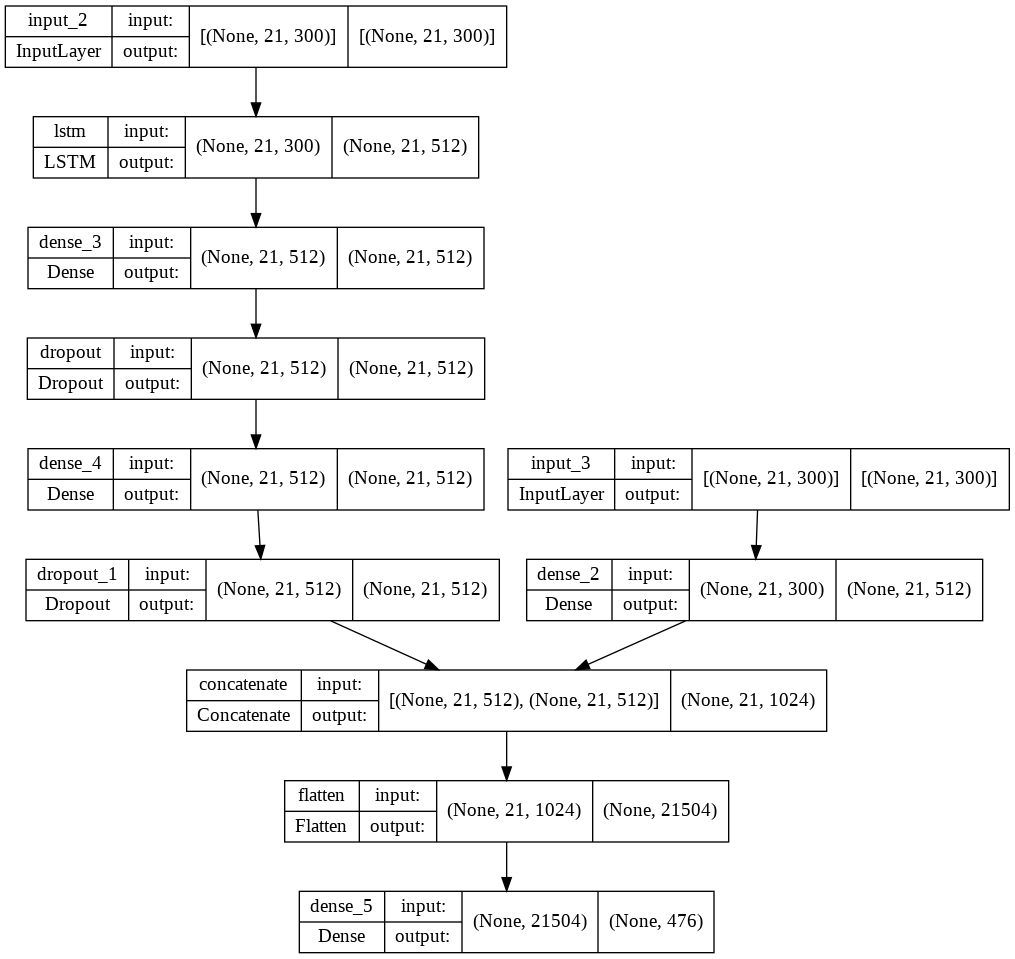

In [ ]:
from keras.utils.vis_utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss ='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
answers = tf.keras.utils.to_categorical(ans)
answers.shape

(1300, 474)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 21, 300)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 21, 512)      1665024     ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 21, 512)      262656      ['lstm[0][0]']                   
                                                                                                  
 dropout (Dropout)              (None, 21, 512)      0           ['dense_3[0][0]']                
                                                                                            

In [ ]:
model.fit([img,que],ans,epochs = 50,batch_size=32,verbose=1)

Epoch 1/50
41/41 [==============================] - 19s 387ms/step - loss: 6.8091 - accuracy: 0.3646
Epoch 2/50
41/41 [==============================] - 16s 381ms/step - loss: 1.9799 - accuracy: 0.6431
Epoch 3/50
41/41 [==============================] - 16s 392ms/step - loss: 1.9622 - accuracy: 0.7062
Epoch 4/50
41/41 [==============================] - 15s 364ms/step - loss: 2.1183 - accuracy: 0.7169
Epoch 5/50
41/41 [==============================] - 15s 363ms/step - loss: 2.5262 - accuracy: 0.7085
Epoch 6/50
41/41 [==============================] - 15s 365ms/step - loss: 2.8808 - accuracy: 0.7392
Epoch 7/50
41/41 [==============================] - 16s 387ms/step - loss: 2.9903 - accuracy: 0.7638
Epoch 8/50
41/41 [==============================] - 15s 366ms/step - loss: 3.4383 - accuracy: 0.7546
Epoch 9/50
41/41 [==============================] - 15s 370ms/step - loss: 3.2378 - accuracy: 0.7731
Epoch 10/50
41/41 [==============================] - 15s 366ms/step - loss: 3.2477 - accura

In [ ]:
model.save('/content/drive/MyDrive/Nagasaki Internship/VQA_Model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Nagasaki Internship/VQA_Model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Nagasaki Internship/VQA_Model/assets


In [ ]:
prediction = tf.argmax(model.predict([img,que]),axis=1).numpy()

In [ ]:
import json
x = open('/content/drive/MyDrive/Nagasaki Internship/med-vqa-main/trainset.json','r')
train = json.load(x)
train[0]

{'answer': 'Yes',
 'answer_type': 'CLOSED',
 'image_name': 'synpic54610.jpg',
 'image_organ': 'HEAD',
 'phrase_type': 'freeform',
 'qid': 1,
 'question': 'Are regions of the brain infarcted?',
 'question_type': 'PRES'}

The Question is: Is/Are there a Pleural effusion?
The answer is: Actual: No predicted value: lungs bony thoracic cavit y mediastinum and great vessels
**************************************************


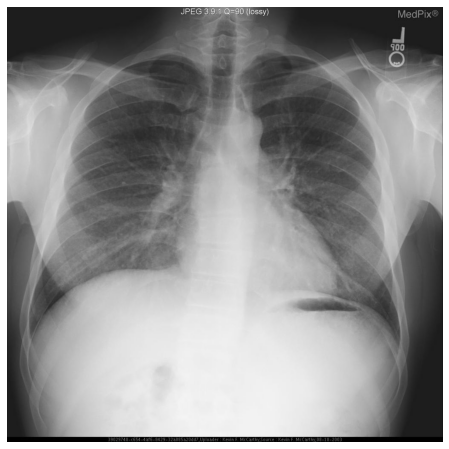

The Question is: Is a pleural effusion present?
The answer is: Actual: No predicted value: yes
**************************************************


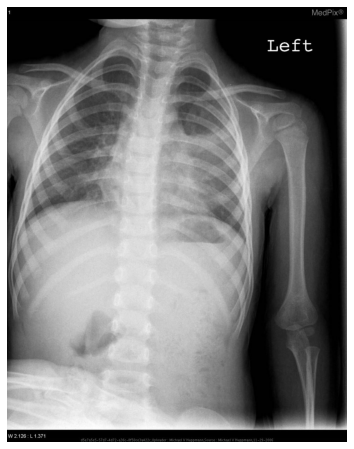

The Question is: Is there a pleural effusion?
The answer is: Actual: No predicted value: yes
**************************************************


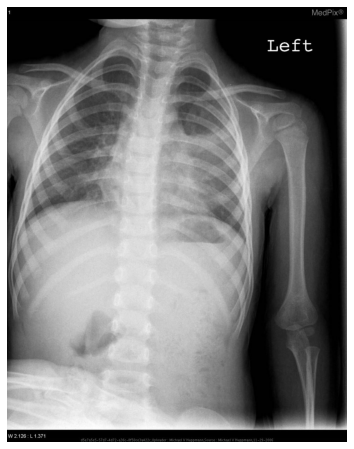

The Question is: Is the heart size abnormal?
The answer is: Actual: No predicted value: less than half thorax
**************************************************


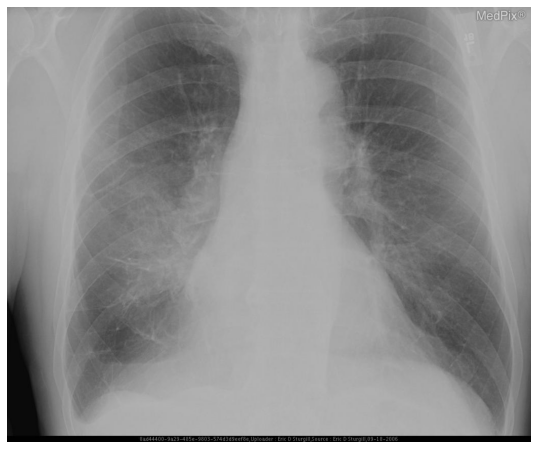

The Question is: Is the heart enlarged?
The answer is: Actual: No predicted value: less than half thorax
**************************************************


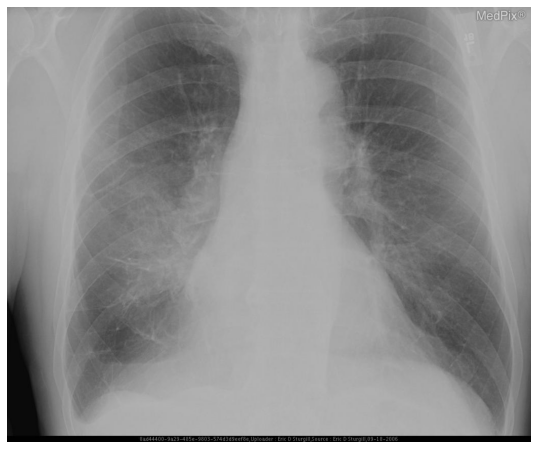

In [ ]:
import pickle
x = open('/content/drive/MyDrive/Nagasaki Internship/med-vqa-main/cache/trainval_label2ans.pkl','rb')
a2lab = pickle.load(x)
import cv2
img_path = '/content/drive/MyDrive/Nagasaki Internship/med-vqa-main/VQA_RAD Image Folder/'
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(760,770,2):
  plt.figure(figsize=(10,8))
  image = cv2.imread(img_path+ train[i]['image_name'])
  plt.imshow(image)
  value = "Actual: "+str(train[i]['answer'])+' predicted value: '+ str(a2lab[prediction[i]])
  plt.axis('off')
  print("The Question is:",train[i]['question'])
  print("The answer is:",value)
  print("*"*50)
  plt.show()